# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides=strides)
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [22]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    print ("small_ip_layer_shape ",small_ip_layer.shape)
    
    print ("large_ip_layer_shape ",large_ip_layer.shape)
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    output_small_layer = bilinear_upsample(small_ip_layer)
    
    print ("bilinear_upsample_shape ",output_small_layer.shape)
    
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    output_layer = layers.concatenate([output_small_layer, large_ip_layer])
    
    # TODO Add some number of separable convolution layers
    output_layer_1 = separable_conv2d_batchnorm(output_layer, filters)
    
    output_layer_2 = separable_conv2d_batchnorm(output_layer_1, filters * 2)
    
    return output_layer_2

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [23]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    input_depth = inputs.get_shape().as_list()[3]
    print ("Input depth ", input_depth)
    print("input_shape ",inputs.shape)
    # 1st sep. Convolution 
    input_layer_1 = encoder_block(inputs, input_depth * 8, 2)
    print("input_layer_1_shape ",input_layer_1.shape)
    # 2nd sep. Convolution 
    input_layer_2 = encoder_block(input_layer_1, input_depth * 16, 2)
    # 3rd sep. Convolution 
    input_layer_3 = encoder_block(input_layer_2, input_depth * 32, 2)
    input_layer_4 = encoder_block(input_layer_3, input_depth * 64, 2)
    input_layer_5 = encoder_block(input_layer_4, input_depth * 128, 2)
    print("input_layer_2_shape ",input_layer_2.shape)
    # Add 1x1 Convolution layer using conv2d_batchnorm().
    input_layer_final = conv2d_batchnorm(input_layer=input_layer_5, filters=input_depth*256, kernel_size=1, strides=1)
    print("input_layer_final_shape ",input_layer_final.shape)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    decode_layer_1 = decoder_block(input_layer_final, input_layer_4, input_depth * 128)
    decode_layer_2 = decoder_block(decode_layer_1, input_layer_3, input_depth * 64)
    decode_layer_3 = decoder_block(decode_layer_2, input_layer_2, input_depth * 32)
    decode_layer_4 = decoder_block(decode_layer_3, input_layer_1, input_depth * 16)
    x = decoder_block(decode_layer_4, inputs, input_depth * 8)
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [24]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

Input depth  3
input_shape  (?, 160, 160, 3)
input_layer_1_shape  (?, 80, 80, 24)
input_layer_2_shape  (?, 40, 40, 48)
input_layer_final_shape  (?, 5, 5, 768)
small_ip_layer_shape  (?, 5, 5, 768)
large_ip_layer_shape  (?, 10, 10, 192)
bilinear_upsample_shape  (?, 10, 10, 768)
small_ip_layer_shape  (?, 10, 10, 768)
large_ip_layer_shape  (?, 20, 20, 96)
bilinear_upsample_shape  (?, 20, 20, 768)
small_ip_layer_shape  (?, 20, 20, 384)
large_ip_layer_shape  (?, 40, 40, 48)
bilinear_upsample_shape  (?, 40, 40, 384)
small_ip_layer_shape  (?, 40, 40, 192)
large_ip_layer_shape  (?, 80, 80, 24)
bilinear_upsample_shape  (?, 80, 80, 192)
small_ip_layer_shape  (?, 80, 80, 96)
large_ip_layer_shape  (?, 160, 160, 3)
bilinear_upsample_shape  (?, 160, 160, 96)


### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [25]:
learning_rate = 0.0005
batch_size = 100
num_epochs = 150
steps_per_epoch = 100
validation_steps = 50
workers = 4

Epoch 1/150
 99/100 [============================>.] - ETA: 2s - loss: 0.7791

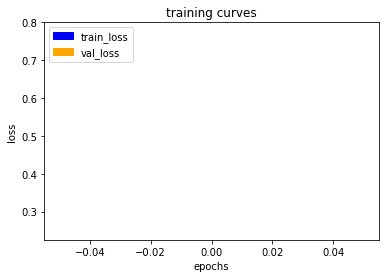

100/100 [==============================] - 283s - loss: 0.7736 - val_loss: 0.2515
Epoch 2/150
 99/100 [============================>.] - ETA: 2s - loss: 0.1202

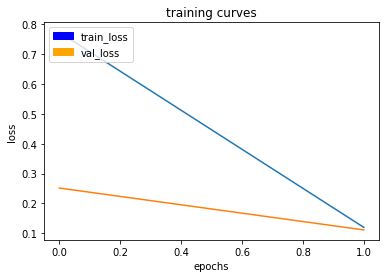

100/100 [==============================] - 280s - loss: 0.1198 - val_loss: 0.1112
Epoch 3/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0718

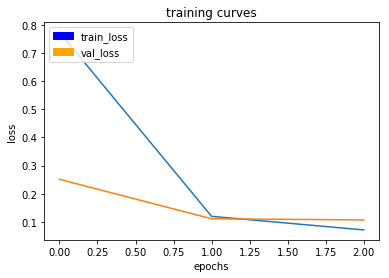

100/100 [==============================] - 278s - loss: 0.0716 - val_loss: 0.1072
Epoch 4/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0626

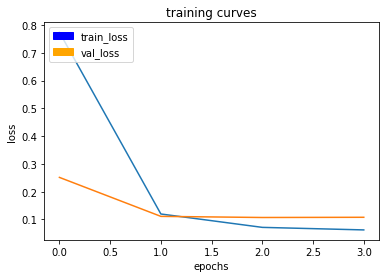

100/100 [==============================] - 279s - loss: 0.0625 - val_loss: 0.1079
Epoch 5/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0571

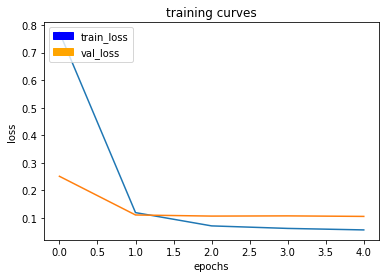

100/100 [==============================] - 277s - loss: 0.0570 - val_loss: 0.1060
Epoch 6/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0562

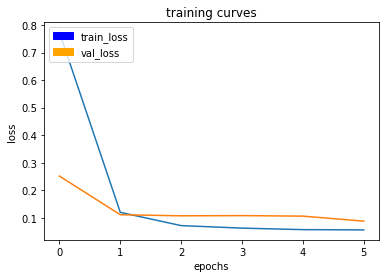

100/100 [==============================] - 279s - loss: 0.0560 - val_loss: 0.0878
Epoch 7/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0518

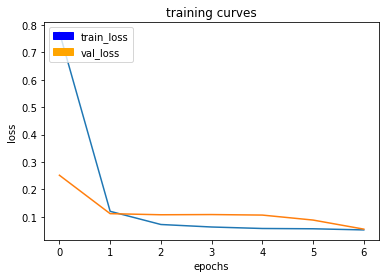

100/100 [==============================] - 277s - loss: 0.0518 - val_loss: 0.0547
Epoch 8/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0529

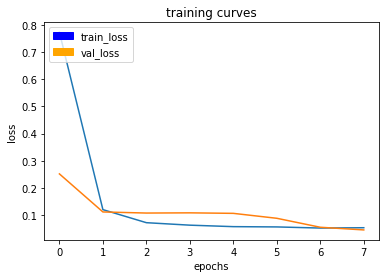

100/100 [==============================] - 277s - loss: 0.0531 - val_loss: 0.0450
Epoch 9/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0493

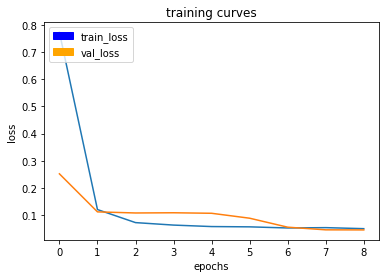

100/100 [==============================] - 279s - loss: 0.0493 - val_loss: 0.0447
Epoch 10/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0478

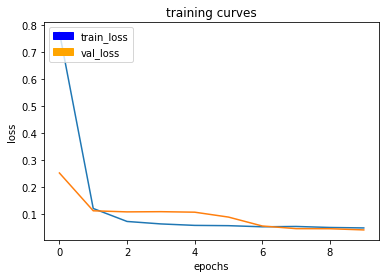

100/100 [==============================] - 278s - loss: 0.0476 - val_loss: 0.0402
Epoch 11/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0478

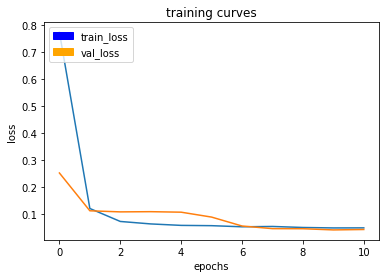

100/100 [==============================] - 279s - loss: 0.0478 - val_loss: 0.0418
Epoch 12/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0462

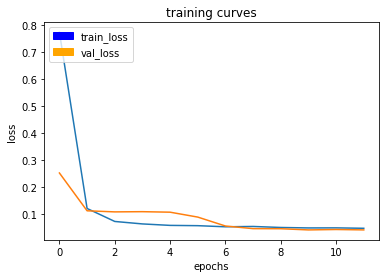

100/100 [==============================] - 277s - loss: 0.0463 - val_loss: 0.0403
Epoch 13/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0447

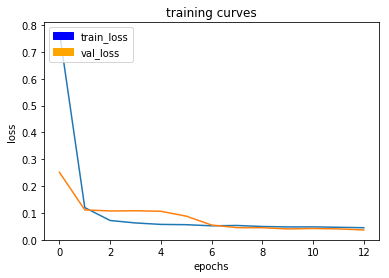

100/100 [==============================] - 280s - loss: 0.0447 - val_loss: 0.0365
Epoch 14/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0433

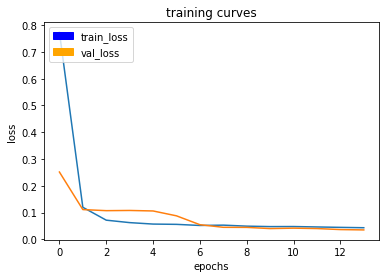

100/100 [==============================] - 278s - loss: 0.0434 - val_loss: 0.0352
Epoch 15/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0425

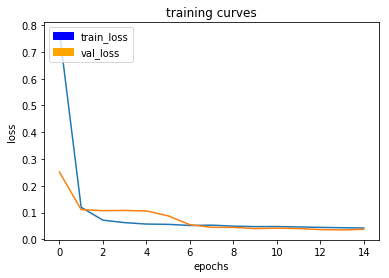

100/100 [==============================] - 280s - loss: 0.0424 - val_loss: 0.0375
Epoch 16/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0453

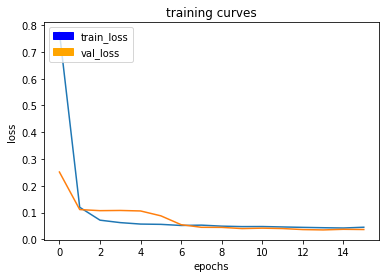

100/100 [==============================] - 280s - loss: 0.0453 - val_loss: 0.0367
Epoch 17/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0417

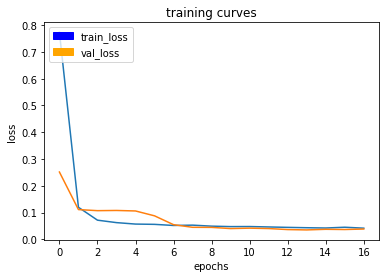

100/100 [==============================] - 277s - loss: 0.0417 - val_loss: 0.0385
Epoch 18/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0416

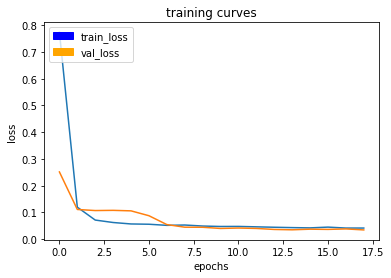

100/100 [==============================] - 279s - loss: 0.0418 - val_loss: 0.0348
Epoch 19/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0417

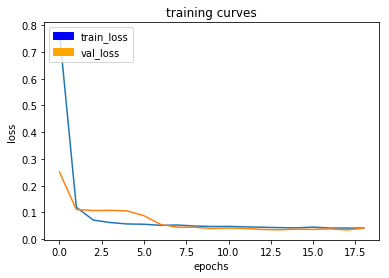

100/100 [==============================] - 278s - loss: 0.0417 - val_loss: 0.0411
Epoch 20/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0408

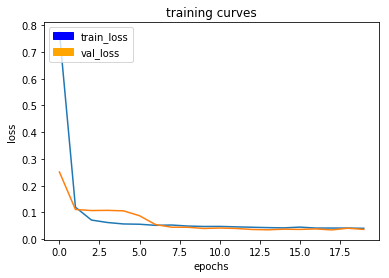

100/100 [==============================] - 278s - loss: 0.0408 - val_loss: 0.0366
Epoch 21/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0397

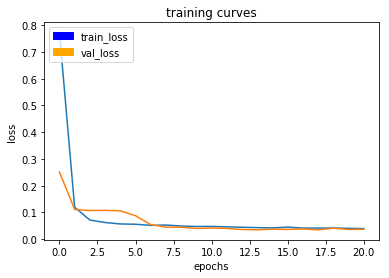

100/100 [==============================] - 278s - loss: 0.0396 - val_loss: 0.0373
Epoch 22/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0409

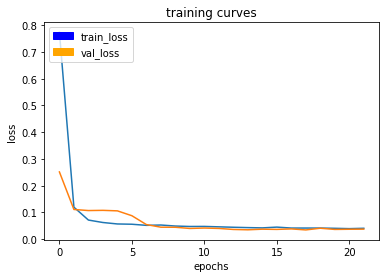

100/100 [==============================] - 279s - loss: 0.0409 - val_loss: 0.0377
Epoch 23/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0387

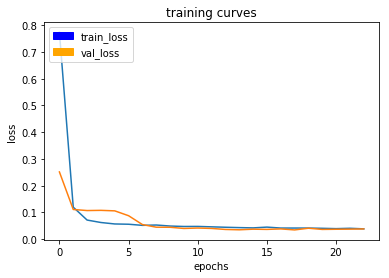

100/100 [==============================] - 281s - loss: 0.0388 - val_loss: 0.0385
Epoch 24/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0393

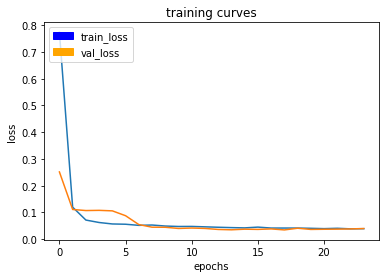

100/100 [==============================] - 280s - loss: 0.0393 - val_loss: 0.0399
Epoch 25/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0380

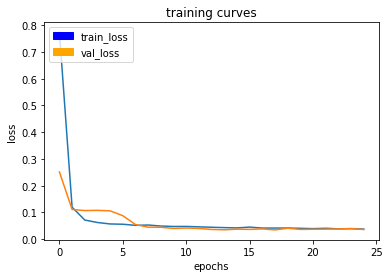

100/100 [==============================] - 280s - loss: 0.0380 - val_loss: 0.0363
Epoch 26/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0368

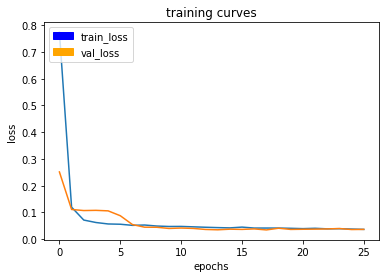

100/100 [==============================] - 277s - loss: 0.0368 - val_loss: 0.0368
Epoch 27/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0378

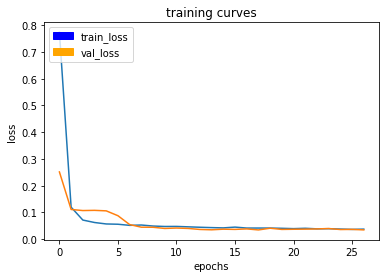

100/100 [==============================] - 279s - loss: 0.0377 - val_loss: 0.0349
Epoch 28/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0370

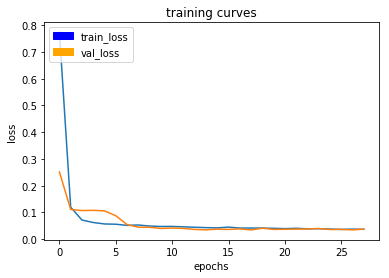

100/100 [==============================] - 277s - loss: 0.0370 - val_loss: 0.0378
Epoch 29/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0358

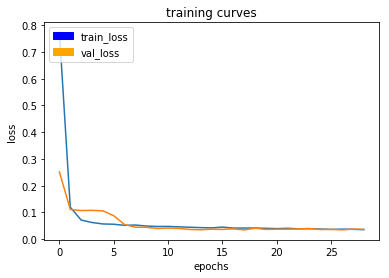

100/100 [==============================] - 278s - loss: 0.0357 - val_loss: 0.0373
Epoch 30/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0526

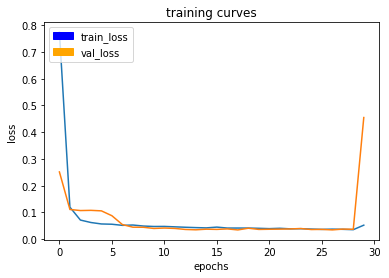

100/100 [==============================] - 279s - loss: 0.0525 - val_loss: 0.4548
Epoch 31/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0483

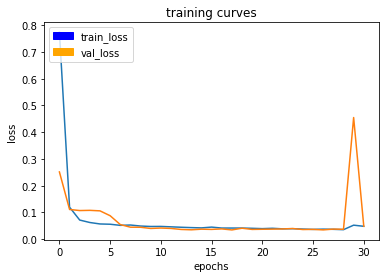

100/100 [==============================] - 277s - loss: 0.0483 - val_loss: 0.0485
Epoch 32/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0437

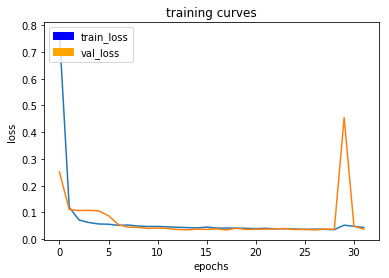

100/100 [==============================] - 279s - loss: 0.0438 - val_loss: 0.0378
Epoch 33/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0440

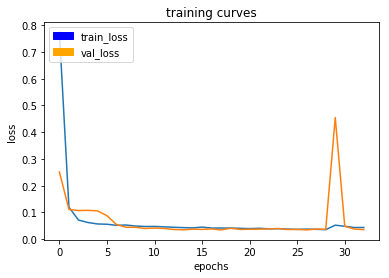

100/100 [==============================] - 278s - loss: 0.0440 - val_loss: 0.0361
Epoch 34/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0400

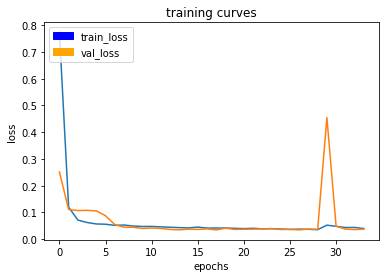

100/100 [==============================] - 281s - loss: 0.0400 - val_loss: 0.0377
Epoch 35/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0529

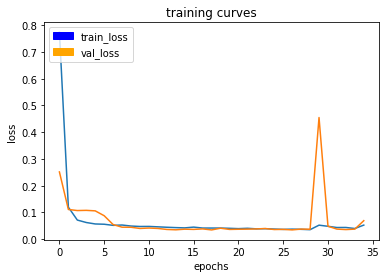

100/100 [==============================] - 279s - loss: 0.0528 - val_loss: 0.0693
Epoch 36/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0462

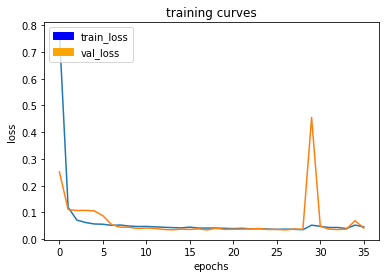

100/100 [==============================] - 277s - loss: 0.0462 - val_loss: 0.0414
Epoch 37/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0443

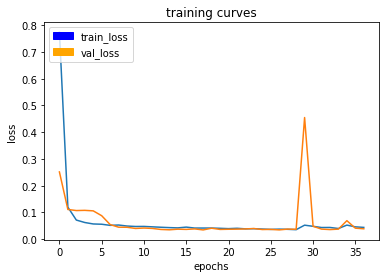

100/100 [==============================] - 279s - loss: 0.0442 - val_loss: 0.0390
Epoch 38/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0438

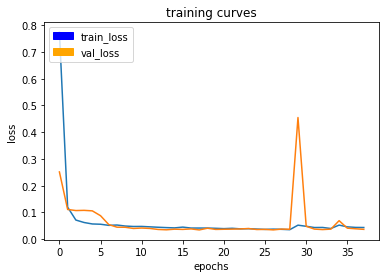

100/100 [==============================] - 277s - loss: 0.0438 - val_loss: 0.0369
Epoch 39/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0408

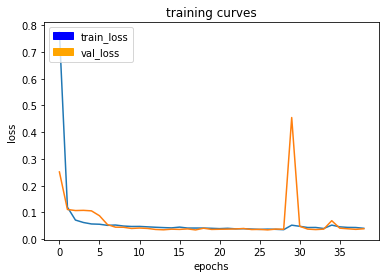

100/100 [==============================] - 279s - loss: 0.0408 - val_loss: 0.0391
Epoch 40/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0409

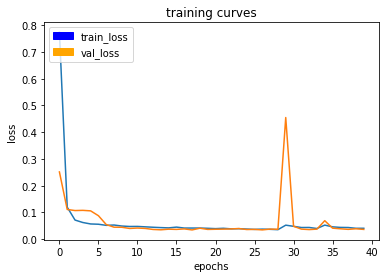

100/100 [==============================] - 278s - loss: 0.0409 - val_loss: 0.0367
Epoch 41/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0402

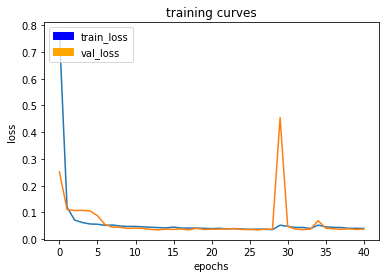

100/100 [==============================] - 278s - loss: 0.0402 - val_loss: 0.0379
Epoch 42/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0369

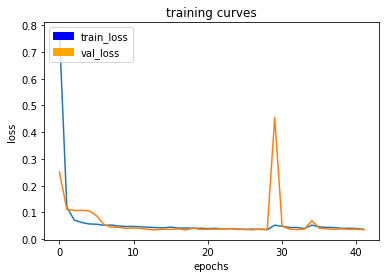

100/100 [==============================] - 278s - loss: 0.0370 - val_loss: 0.0352
Epoch 43/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0374

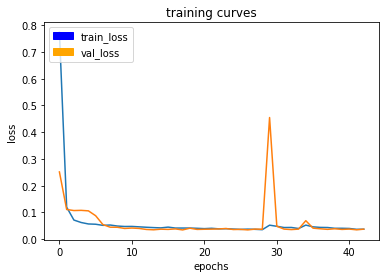

100/100 [==============================] - 277s - loss: 0.0375 - val_loss: 0.0376
Epoch 44/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0393

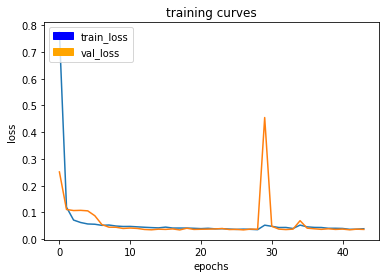

100/100 [==============================] - 279s - loss: 0.0392 - val_loss: 0.0366
Epoch 45/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0356

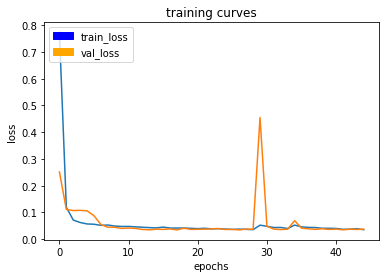

100/100 [==============================] - 278s - loss: 0.0356 - val_loss: 0.0373
Epoch 46/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0364

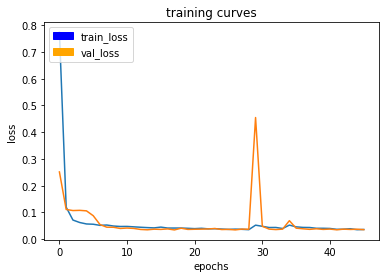

100/100 [==============================] - 279s - loss: 0.0364 - val_loss: 0.0358
Epoch 47/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0360

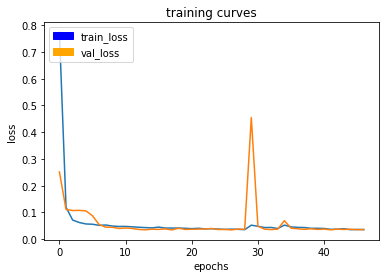

100/100 [==============================] - 280s - loss: 0.0360 - val_loss: 0.0363
Epoch 48/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0346

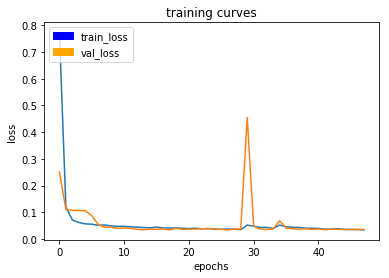

100/100 [==============================] - 279s - loss: 0.0345 - val_loss: 0.0363
Epoch 49/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0343

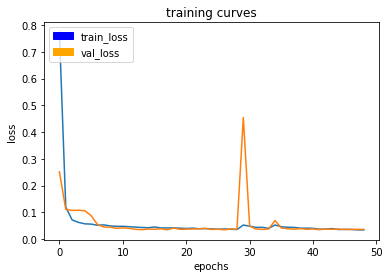

100/100 [==============================] - 278s - loss: 0.0343 - val_loss: 0.0363
Epoch 50/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0342

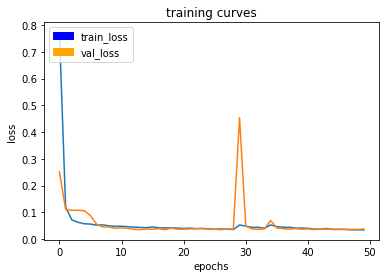

100/100 [==============================] - 279s - loss: 0.0341 - val_loss: 0.0377
Epoch 51/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0320

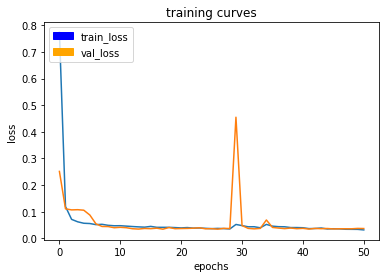

100/100 [==============================] - 279s - loss: 0.0320 - val_loss: 0.0372
Epoch 52/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0331

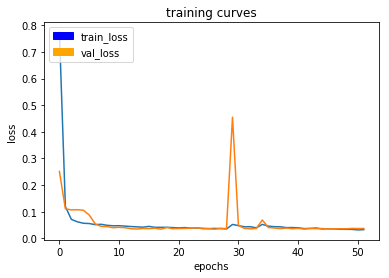

100/100 [==============================] - 277s - loss: 0.0331 - val_loss: 0.0375
Epoch 53/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0328

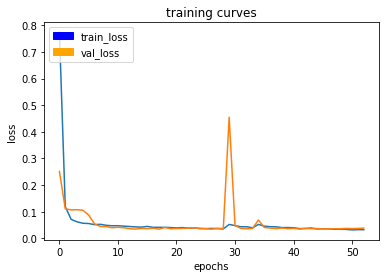

100/100 [==============================] - 279s - loss: 0.0327 - val_loss: 0.0390
Epoch 54/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0310

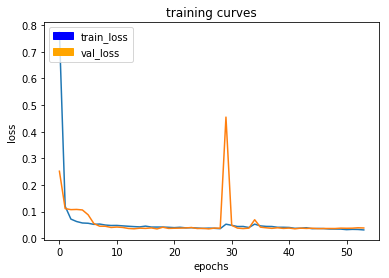

100/100 [==============================] - 278s - loss: 0.0310 - val_loss: 0.0383
Epoch 55/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0317

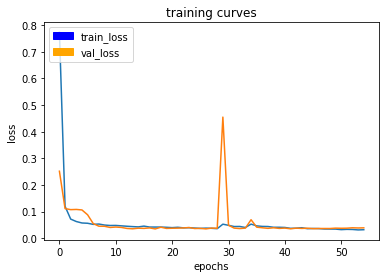

100/100 [==============================] - 280s - loss: 0.0317 - val_loss: 0.0388
Epoch 56/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0294

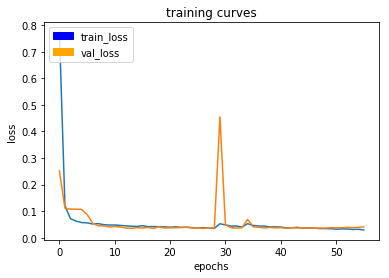

100/100 [==============================] - 279s - loss: 0.0293 - val_loss: 0.0407
Epoch 57/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0299

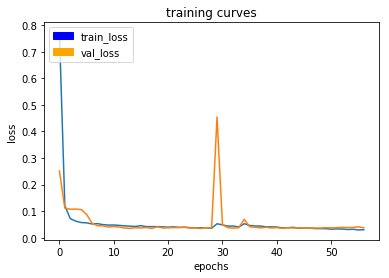

100/100 [==============================] - 278s - loss: 0.0301 - val_loss: 0.0374
Epoch 58/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0300

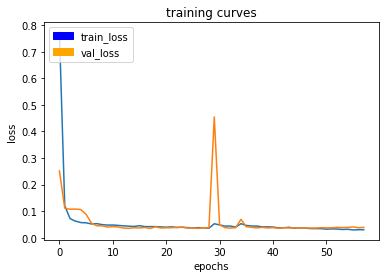

100/100 [==============================] - 279s - loss: 0.0301 - val_loss: 0.0389
Epoch 59/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0290

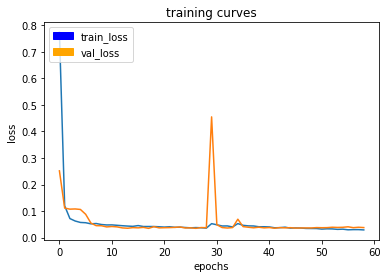

100/100 [==============================] - 278s - loss: 0.0289 - val_loss: 0.0377
Epoch 60/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0288

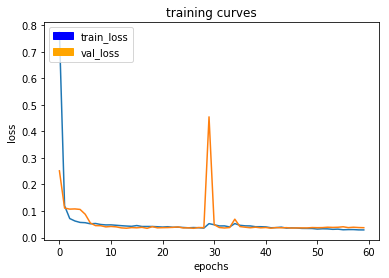

100/100 [==============================] - 278s - loss: 0.0288 - val_loss: 0.0372
Epoch 61/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0285

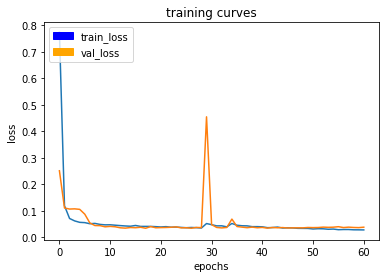

100/100 [==============================] - 278s - loss: 0.0285 - val_loss: 0.0388
Epoch 62/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0279

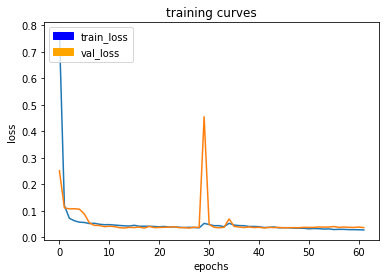

100/100 [==============================] - 277s - loss: 0.0279 - val_loss: 0.0367
Epoch 63/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0280

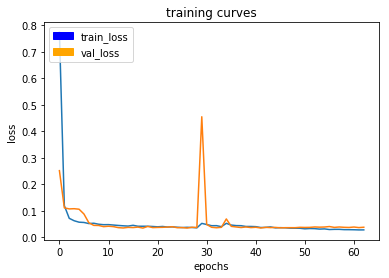

100/100 [==============================] - 280s - loss: 0.0280 - val_loss: 0.0380
Epoch 64/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0266

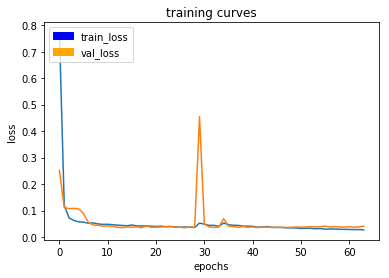

100/100 [==============================] - 277s - loss: 0.0266 - val_loss: 0.0407
Epoch 65/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0267

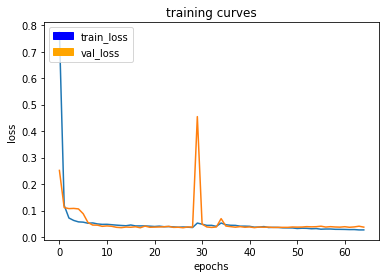

100/100 [==============================] - 279s - loss: 0.0267 - val_loss: 0.0371
Epoch 66/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0268

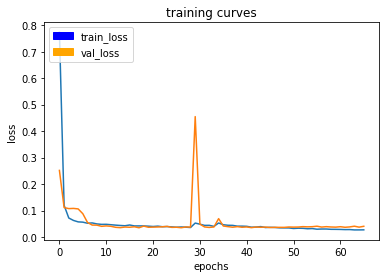

100/100 [==============================] - 279s - loss: 0.0269 - val_loss: 0.0403
Epoch 67/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0253

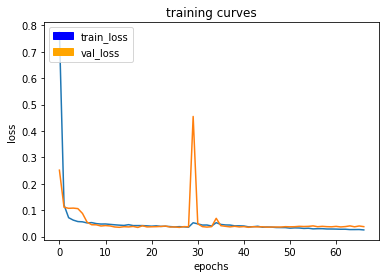

100/100 [==============================] - 279s - loss: 0.0254 - val_loss: 0.0378
Epoch 68/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0258

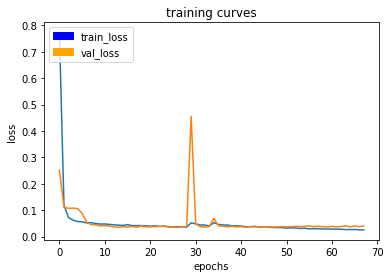

100/100 [==============================] - 279s - loss: 0.0257 - val_loss: 0.0408
Epoch 69/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0260

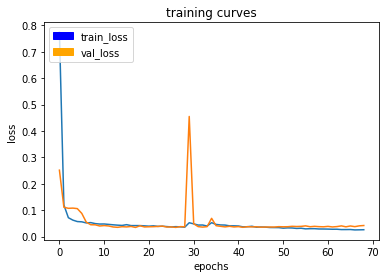

100/100 [==============================] - 279s - loss: 0.0261 - val_loss: 0.0420
Epoch 70/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0251

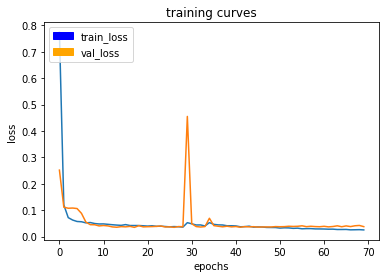

100/100 [==============================] - 280s - loss: 0.0251 - val_loss: 0.0375
Epoch 71/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0249

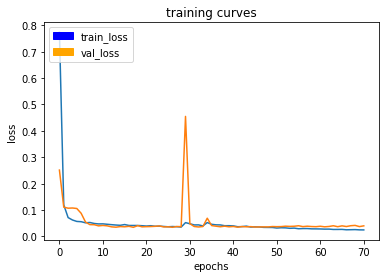

100/100 [==============================] - 278s - loss: 0.0249 - val_loss: 0.0403
Epoch 72/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0245

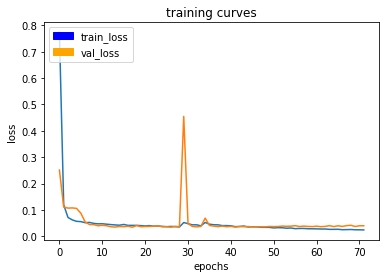

100/100 [==============================] - 280s - loss: 0.0245 - val_loss: 0.0403
Epoch 73/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0239

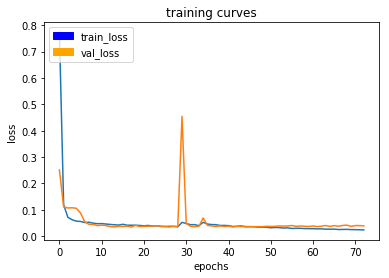

100/100 [==============================] - 280s - loss: 0.0239 - val_loss: 0.0394
Epoch 74/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0248

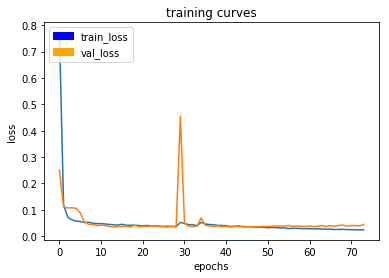

100/100 [==============================] - 278s - loss: 0.0248 - val_loss: 0.0448
Epoch 75/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0240

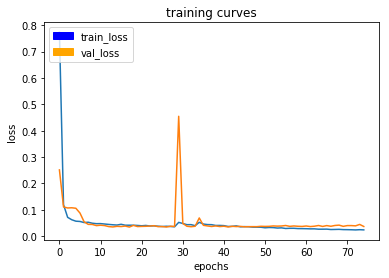

100/100 [==============================] - 279s - loss: 0.0240 - val_loss: 0.0370
Epoch 76/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0232

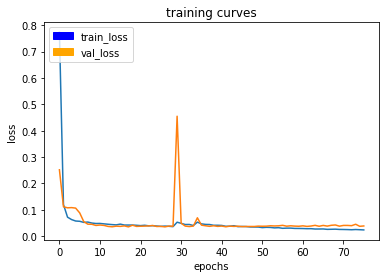

100/100 [==============================] - 278s - loss: 0.0233 - val_loss: 0.0383
Epoch 77/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0241

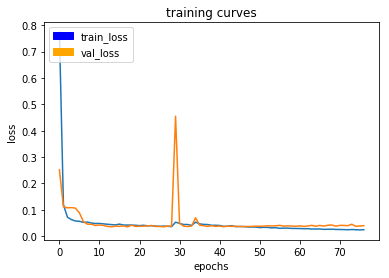

100/100 [==============================] - 278s - loss: 0.0240 - val_loss: 0.0394
Epoch 78/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0230

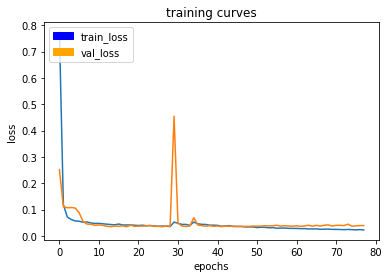

100/100 [==============================] - 279s - loss: 0.0230 - val_loss: 0.0396
Epoch 79/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0229

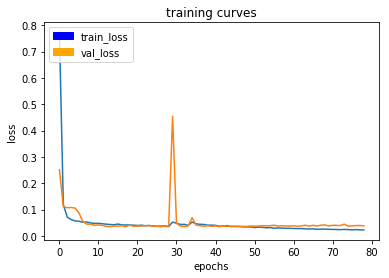

100/100 [==============================] - 279s - loss: 0.0229 - val_loss: 0.0384
Epoch 80/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0232

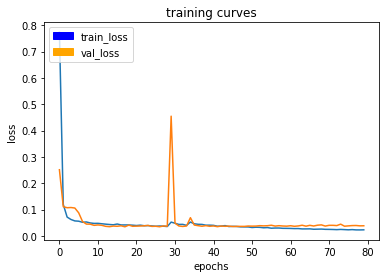

100/100 [==============================] - 278s - loss: 0.0232 - val_loss: 0.0386
Epoch 81/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0222

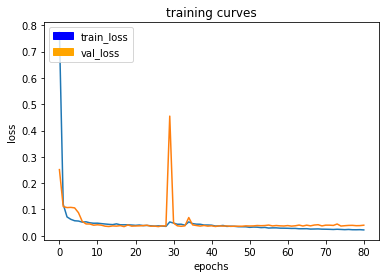

100/100 [==============================] - 279s - loss: 0.0223 - val_loss: 0.0402
Epoch 82/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0235

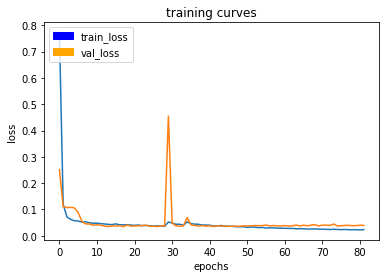

100/100 [==============================] - 277s - loss: 0.0235 - val_loss: 0.0396
Epoch 83/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0223

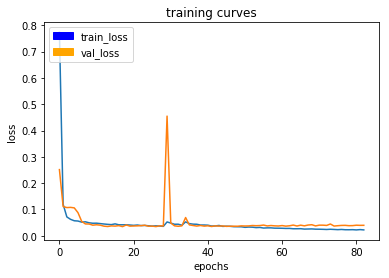

100/100 [==============================] - 277s - loss: 0.0223 - val_loss: 0.0398
Epoch 84/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0223

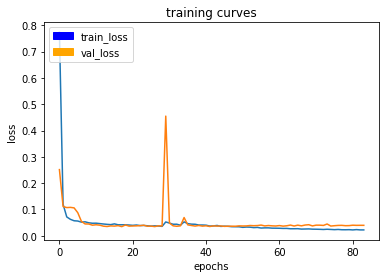

100/100 [==============================] - 277s - loss: 0.0223 - val_loss: 0.0397
Epoch 85/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0220

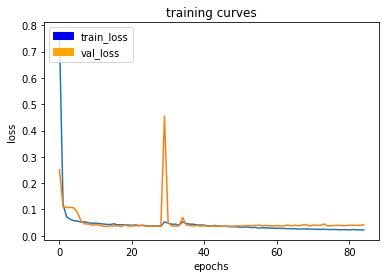

100/100 [==============================] - 278s - loss: 0.0221 - val_loss: 0.0414
Epoch 86/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0218

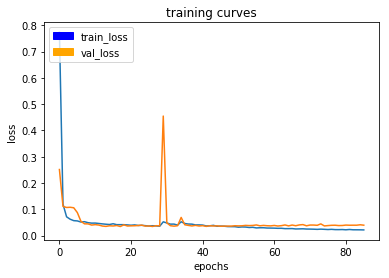

100/100 [==============================] - 278s - loss: 0.0218 - val_loss: 0.0398
Epoch 87/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0213

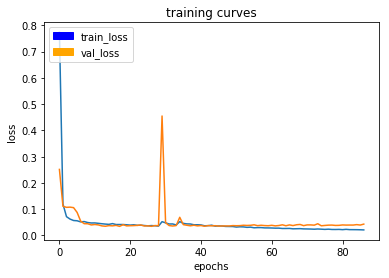

100/100 [==============================] - 278s - loss: 0.0212 - val_loss: 0.0433
Epoch 88/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0217

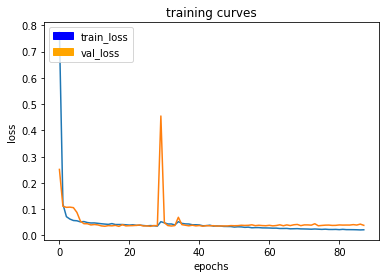

100/100 [==============================] - 279s - loss: 0.0217 - val_loss: 0.0387
Epoch 89/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0202

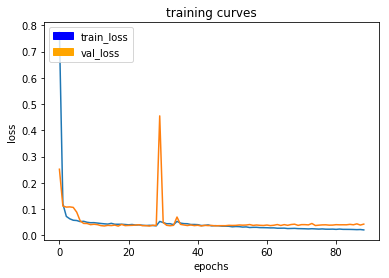

100/100 [==============================] - 279s - loss: 0.0202 - val_loss: 0.0423
Epoch 90/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0212

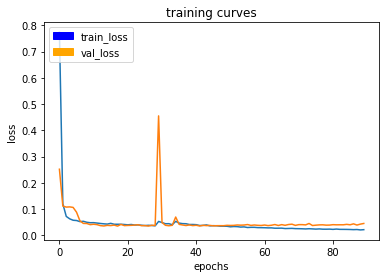

100/100 [==============================] - 278s - loss: 0.0211 - val_loss: 0.0448
Epoch 91/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0211

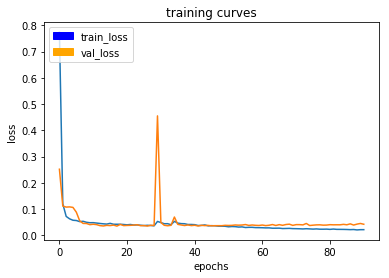

100/100 [==============================] - 279s - loss: 0.0211 - val_loss: 0.0418
Epoch 92/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0203

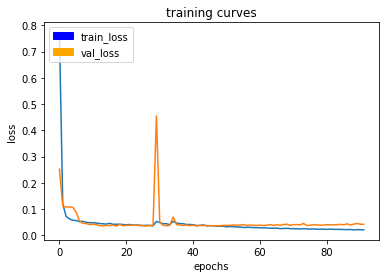

100/100 [==============================] - 279s - loss: 0.0204 - val_loss: 0.0416
Epoch 93/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0209

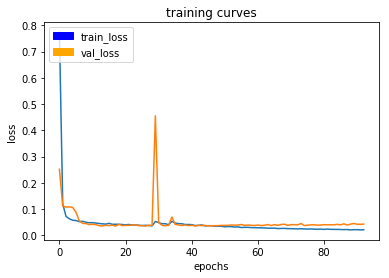

100/100 [==============================] - 280s - loss: 0.0209 - val_loss: 0.0425
Epoch 94/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0202

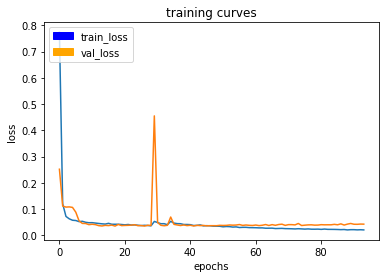

100/100 [==============================] - 279s - loss: 0.0202 - val_loss: 0.0422
Epoch 95/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0202

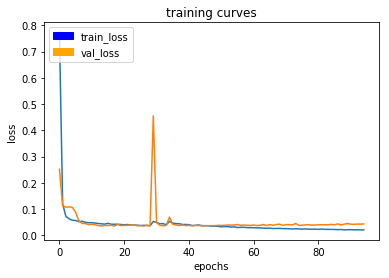

100/100 [==============================] - 280s - loss: 0.0202 - val_loss: 0.0430
Epoch 96/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0203

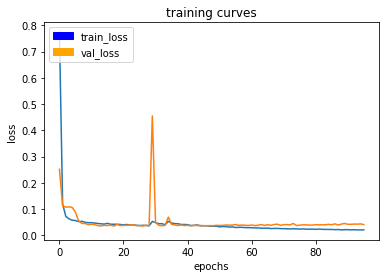

100/100 [==============================] - 279s - loss: 0.0204 - val_loss: 0.0405
Epoch 97/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0199

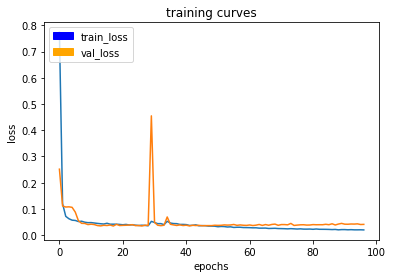

100/100 [==============================] - 279s - loss: 0.0199 - val_loss: 0.0410
Epoch 98/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0195

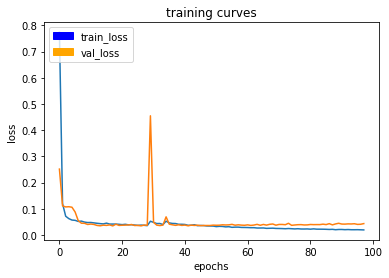

100/100 [==============================] - 281s - loss: 0.0195 - val_loss: 0.0436
Epoch 99/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0200

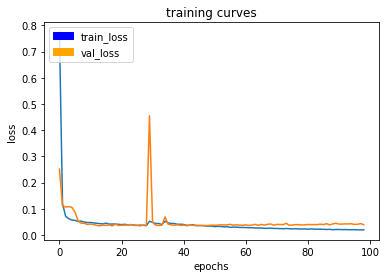

100/100 [==============================] - 280s - loss: 0.0199 - val_loss: 0.0394
Epoch 100/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0197

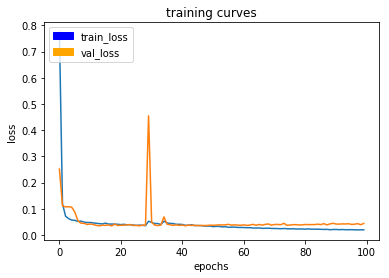

100/100 [==============================] - 280s - loss: 0.0197 - val_loss: 0.0442
Epoch 101/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0192

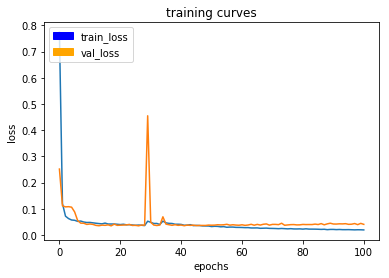

100/100 [==============================] - 280s - loss: 0.0192 - val_loss: 0.0405
Epoch 102/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0195

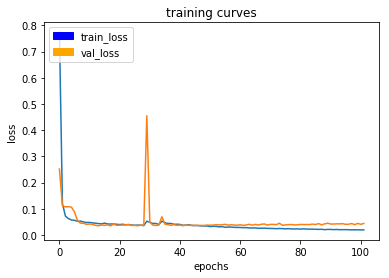

100/100 [==============================] - 279s - loss: 0.0195 - val_loss: 0.0440
Epoch 103/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0194

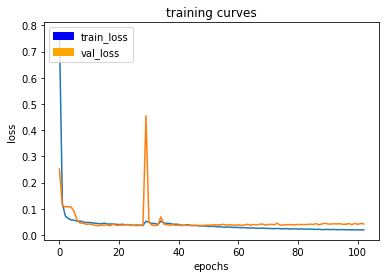

100/100 [==============================] - 280s - loss: 0.0195 - val_loss: 0.0421
Epoch 104/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0191

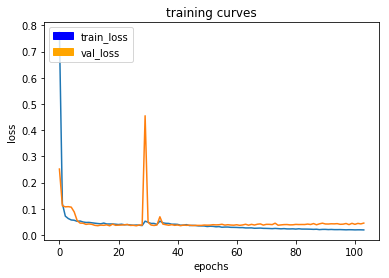

100/100 [==============================] - 280s - loss: 0.0191 - val_loss: 0.0451
Epoch 105/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0192

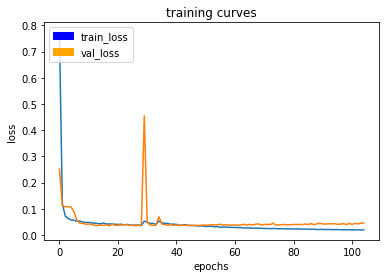

100/100 [==============================] - 279s - loss: 0.0192 - val_loss: 0.0453
Epoch 106/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0184

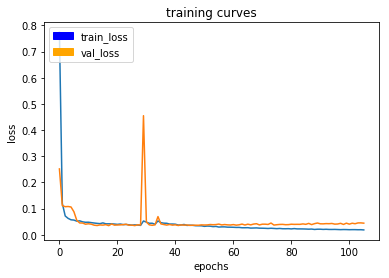

100/100 [==============================] - 279s - loss: 0.0184 - val_loss: 0.0442
Epoch 107/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0190

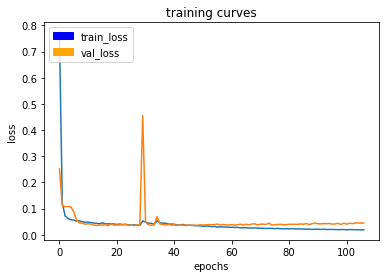

100/100 [==============================] - 280s - loss: 0.0191 - val_loss: 0.0448
Epoch 108/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0187

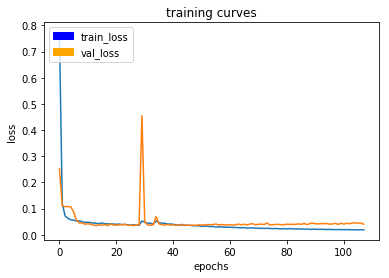

100/100 [==============================] - 280s - loss: 0.0187 - val_loss: 0.0399
Epoch 109/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0183

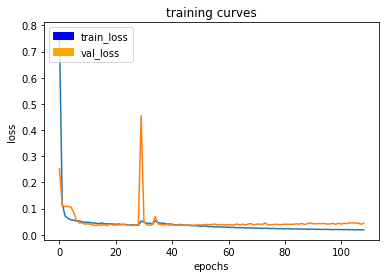

100/100 [==============================] - 279s - loss: 0.0183 - val_loss: 0.0438
Epoch 110/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0190

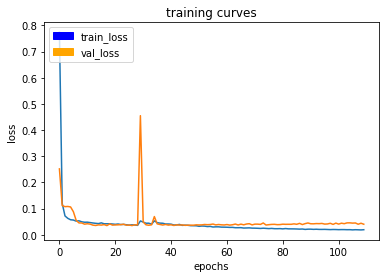

100/100 [==============================] - 280s - loss: 0.0190 - val_loss: 0.0400
Epoch 111/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0183

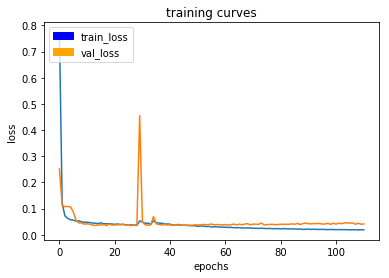

100/100 [==============================] - 280s - loss: 0.0183 - val_loss: 0.0412
Epoch 112/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0186

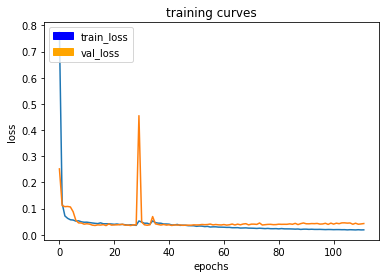

100/100 [==============================] - 279s - loss: 0.0185 - val_loss: 0.0426
Epoch 113/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0181

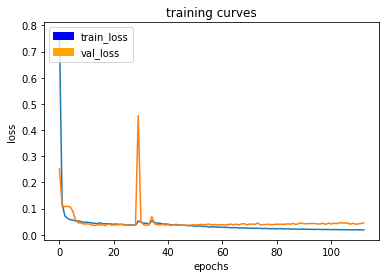

100/100 [==============================] - 279s - loss: 0.0182 - val_loss: 0.0455
Epoch 114/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0179

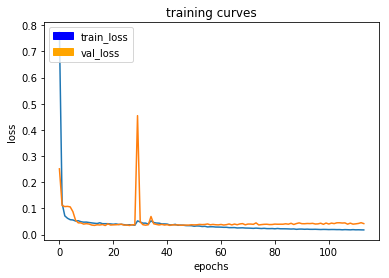

100/100 [==============================] - 279s - loss: 0.0179 - val_loss: 0.0421
Epoch 115/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0178

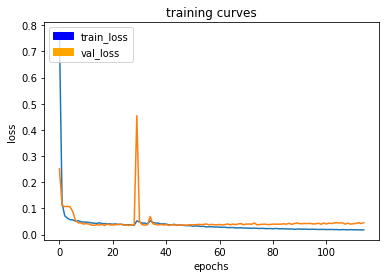

100/100 [==============================] - 280s - loss: 0.0178 - val_loss: 0.0456
Epoch 116/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0180

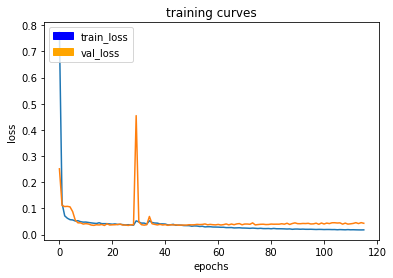

100/100 [==============================] - 280s - loss: 0.0180 - val_loss: 0.0432
Epoch 117/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0176

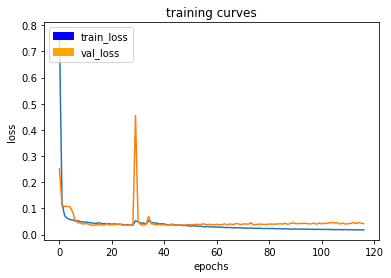

100/100 [==============================] - 279s - loss: 0.0176 - val_loss: 0.0418
Epoch 118/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0175

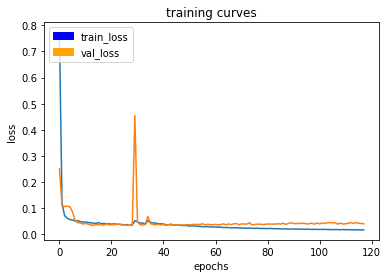

100/100 [==============================] - 280s - loss: 0.0175 - val_loss: 0.0411
Epoch 119/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0177

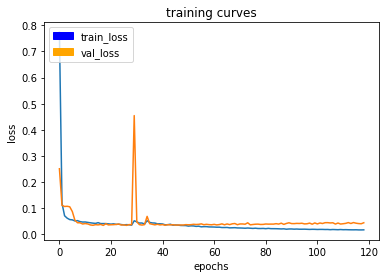

100/100 [==============================] - 279s - loss: 0.0178 - val_loss: 0.0449
Epoch 120/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0176

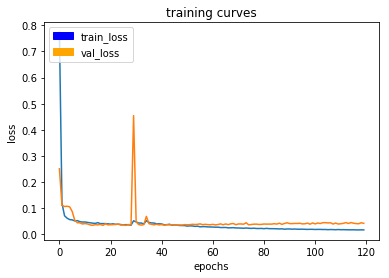

100/100 [==============================] - 279s - loss: 0.0176 - val_loss: 0.0427
Epoch 121/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0207

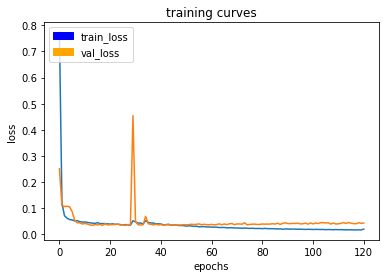

100/100 [==============================] - 279s - loss: 0.0207 - val_loss: 0.0440
Epoch 122/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0184

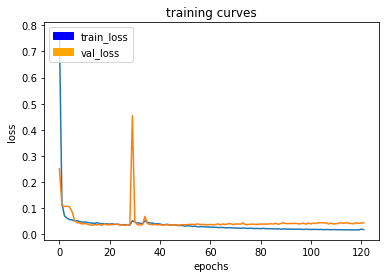

100/100 [==============================] - 280s - loss: 0.0185 - val_loss: 0.0444
Epoch 123/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0188

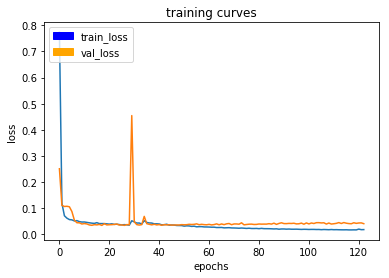

100/100 [==============================] - 280s - loss: 0.0187 - val_loss: 0.0414
Epoch 124/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0182

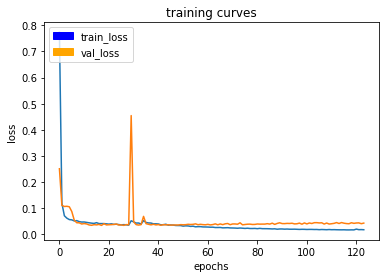

100/100 [==============================] - 279s - loss: 0.0182 - val_loss: 0.0435
Epoch 125/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0174

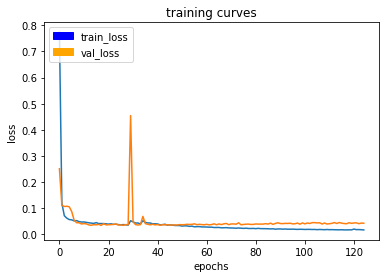

100/100 [==============================] - 280s - loss: 0.0174 - val_loss: 0.0431
Epoch 126/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0172

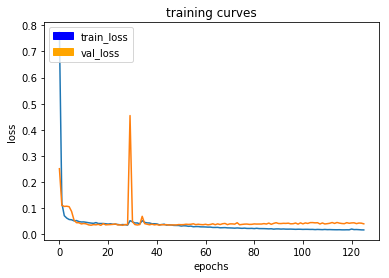

100/100 [==============================] - 280s - loss: 0.0172 - val_loss: 0.0405
Epoch 127/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0171

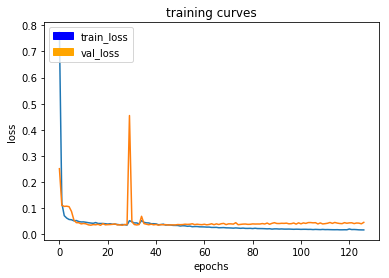

100/100 [==============================] - 279s - loss: 0.0171 - val_loss: 0.0459
Epoch 128/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0163

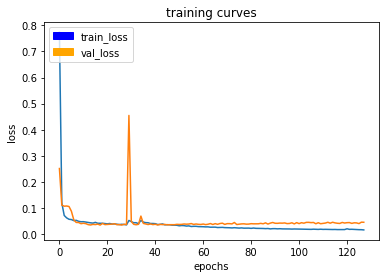

100/100 [==============================] - 279s - loss: 0.0163 - val_loss: 0.0456
Epoch 129/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0166

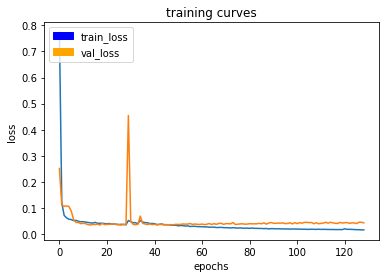

100/100 [==============================] - 280s - loss: 0.0166 - val_loss: 0.0433
Epoch 130/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0167

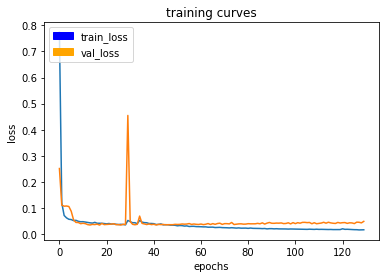

100/100 [==============================] - 279s - loss: 0.0168 - val_loss: 0.0490
Epoch 131/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0158

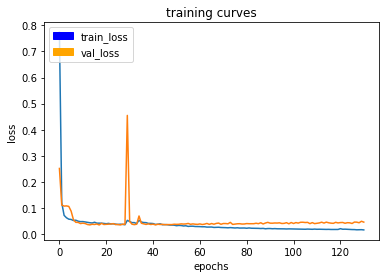

100/100 [==============================] - 279s - loss: 0.0159 - val_loss: 0.0457
Epoch 132/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0164

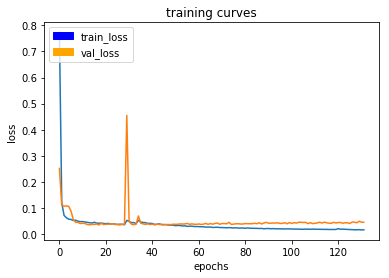

100/100 [==============================] - 279s - loss: 0.0164 - val_loss: 0.0451
Epoch 133/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0157

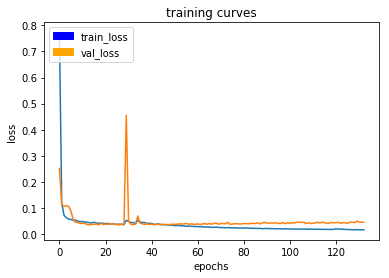

100/100 [==============================] - 279s - loss: 0.0157 - val_loss: 0.0454
Epoch 134/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0162

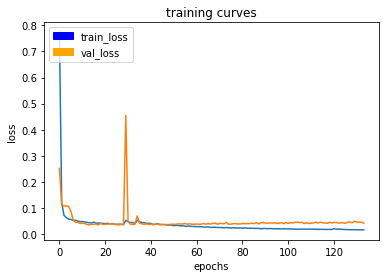

100/100 [==============================] - 279s - loss: 0.0162 - val_loss: 0.0414
Epoch 135/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0163

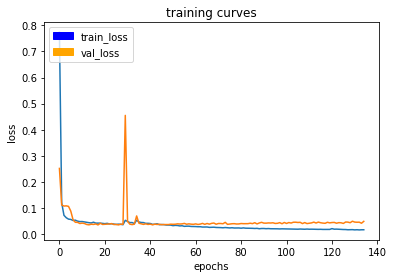

100/100 [==============================] - 280s - loss: 0.0163 - val_loss: 0.0485
Epoch 136/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0158

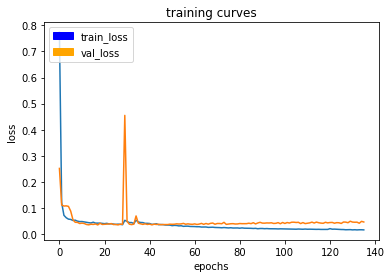

100/100 [==============================] - 280s - loss: 0.0158 - val_loss: 0.0460
Epoch 137/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0162

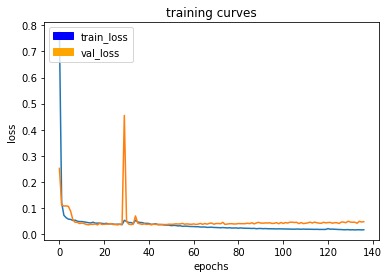

100/100 [==============================] - 279s - loss: 0.0162 - val_loss: 0.0472
Epoch 138/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0161

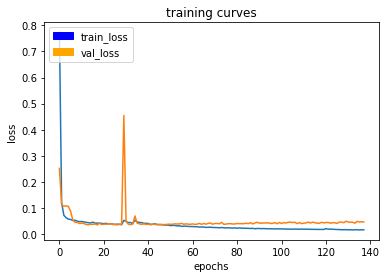

100/100 [==============================] - 279s - loss: 0.0160 - val_loss: 0.0460
Epoch 139/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0158

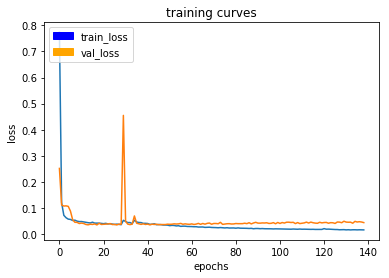

100/100 [==============================] - 280s - loss: 0.0158 - val_loss: 0.0437
Epoch 140/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0161

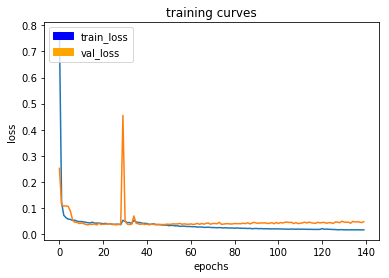

100/100 [==============================] - 281s - loss: 0.0161 - val_loss: 0.0473
Epoch 141/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0167

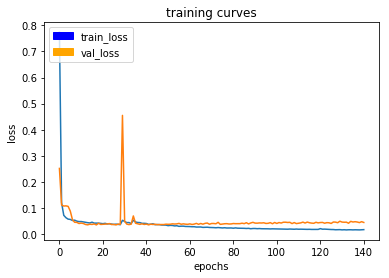

100/100 [==============================] - 279s - loss: 0.0168 - val_loss: 0.0443
Epoch 142/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0161

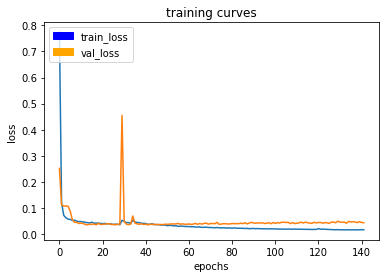

100/100 [==============================] - 279s - loss: 0.0161 - val_loss: 0.0428
Epoch 143/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0164

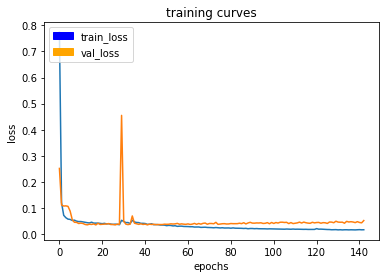

100/100 [==============================] - 279s - loss: 0.0164 - val_loss: 0.0516
Epoch 144/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0161

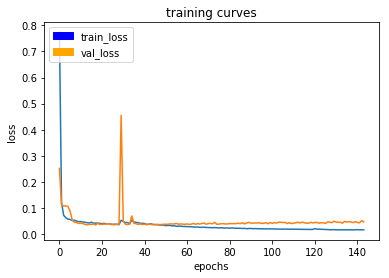

100/100 [==============================] - 279s - loss: 0.0161 - val_loss: 0.0466
Epoch 145/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0161

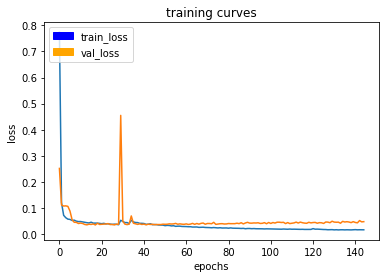

100/100 [==============================] - 279s - loss: 0.0161 - val_loss: 0.0474
Epoch 146/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0162

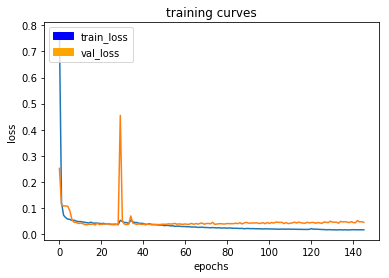

100/100 [==============================] - 279s - loss: 0.0162 - val_loss: 0.0447
Epoch 147/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0159

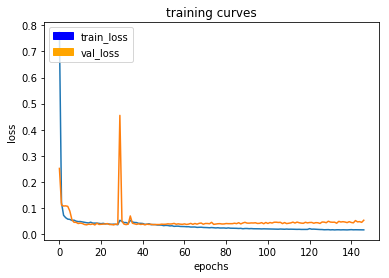

100/100 [==============================] - 280s - loss: 0.0159 - val_loss: 0.0528
Epoch 148/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0157

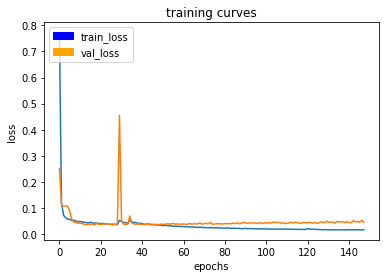

100/100 [==============================] - 279s - loss: 0.0158 - val_loss: 0.0443
Epoch 149/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0162

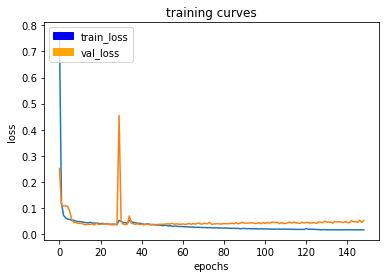

100/100 [==============================] - 279s - loss: 0.0162 - val_loss: 0.0521
Epoch 150/150
 99/100 [============================>.] - ETA: 2s - loss: 0.0155

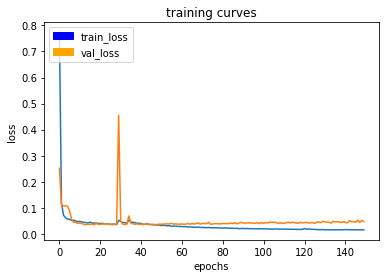

100/100 [==============================] - 280s - loss: 0.0155 - val_loss: 0.0476


In [26]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [27]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [28]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [29]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

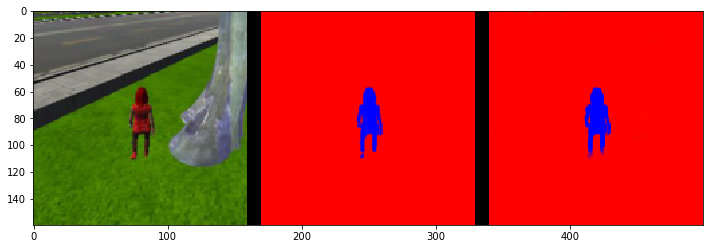

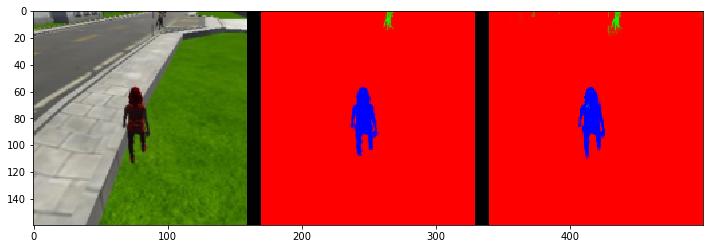

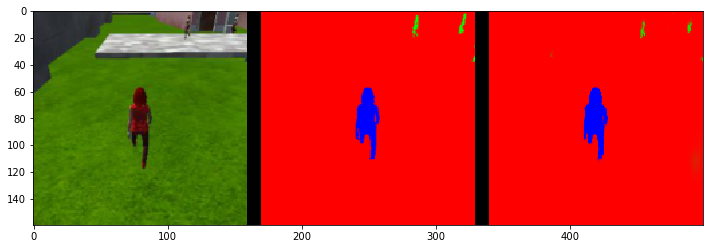

In [30]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

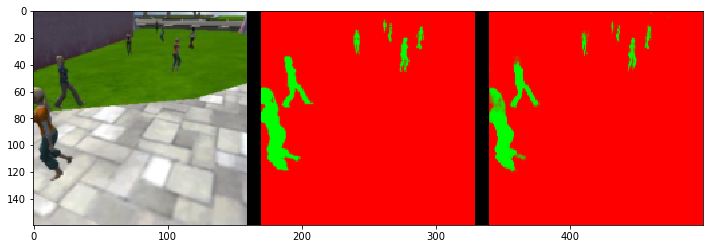

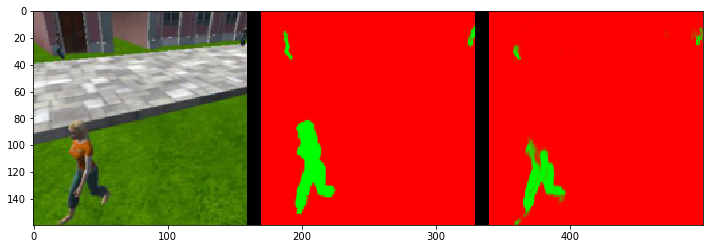

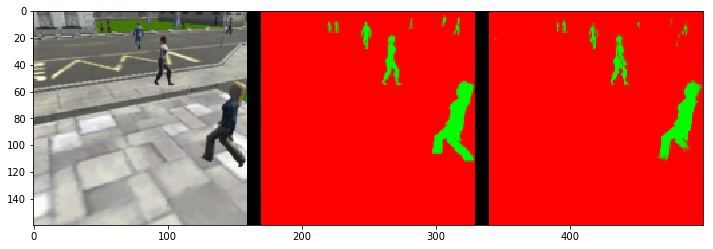

In [31]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

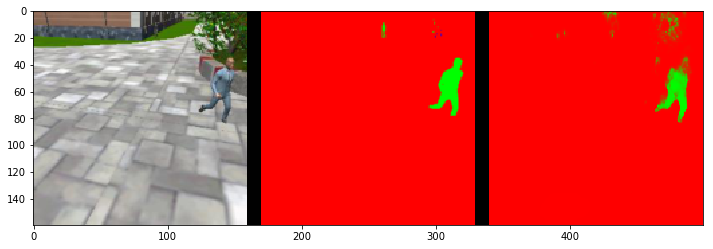

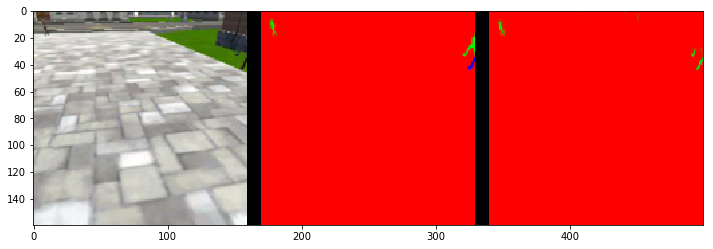

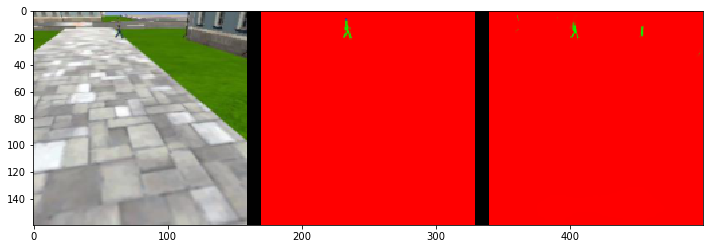

In [32]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [33]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.995587836646173
average intersection over union for other people is 0.3714044923296906
average intersection over union for the hero is 0.9378549264736833
number true positives: 539, number false positives: 0, number false negatives: 0


In [34]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9854257874524838
average intersection over union for other people is 0.7052530591292323
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 19, number false negatives: 0


In [35]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9961743254930342
average intersection over union for other people is 0.44589885597472945
average intersection over union for the hero is 0.2362741982546201
number true positives: 128, number false positives: 1, number false negatives: 173


In [36]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7755813953488372


In [37]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.587064562364


In [38]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.455316352438
